forked from https://github.com/PrinsWu/rnn_tang_poetry   May 15, 2019
Add code for displaying the model by ttc
Modify code for reading big 5 word

# 唐詩三百首藏頭詩產生器

### 中文的困難點
> 一般常見的範例是用英文的，然後拆成字元的形式．但是中文沒辦法這樣做，它每個字都是單獨的．
> 一般的英文字元分類大概3, 40個，但光是用唐詩三百首為資料的詞彙就有2千多個．所以在分類訓練上來說比較難達到精確的結果．

### 以唐詩三百首當訓練的優點
> 資料量適中
> 詩講究的是意境，人腦會自動腦補其句子含義．即使句子不精確但好像還像回事．

### 設計時遇到的問題
> 這原本是Udacity AIND的一個作業，他是用tensorflow實作．我想改成keras來應該是很簡單阿．
在作業裡它已經幫忙把資料處理的架構的寫好，所以只要指定window size, step size就會將資料拆成批次．
但Keras LSTM相對簡單，它只需要決定input一次要給幾個字、output幾個字．

> 因為中文字是方塊字，不是字符組成．而且唐詩的每個字的相關性不需要很久遠前的字來影響．
所以一般英文字的window size設個100，在中文裡就不適合．
又因為最後的結果是要以藏頭詩的形式產生後續的字詞，所以input也只會有一個字．
最後決定就是以1個input對1個output的形式作為LSTM的輸入．

### 資料處理
> 這個部分是最花時間的，除了等待訓練以外．
我記得是從中國的一個網站下載的(資料來源已經忘了，但不得不說中國在資料整理、搜集這方面做的真的比台灣好太多)，
但文字檔裡包含了詩名稱、作者等資訊．但我只要唐詩的部分，所以只好用人工的方式把不要的刪除．

> 因為原始文字檔是簡體編碼，我想看繁體，所以就資料轉成繁體再轉utf8．
我記得有用一些工具還有簡單的pyhon轉檔，但忘記放哪了．網路上應該可以找到方法，如果你要自己整理資料的話．

### 字 vs 詞
> 一開始我有jieba做分詞，感覺會讓詞彙表小一點．但單一字跟jieba分詞的詞彙表數量差不多．
而且分詞沒辦法做藏頭詩．所以最後就用單一字的方式．

### 執行參數

* 如果在本機跑的話，folder='data/'．如果在Google Colab跑要記得指向放訓練文字檔的目錄．
* window_size = 1．也可以改成其他較大的數字，但predict_next_chars可能需要調整．
* one_hot = True．input資料可以指定用one hot vector或是用vocab index．這個例子裡one hot vector的效果比較好．

### Model
> LSTM -> BatchNormalization -> LSTM -> BatchNormalization -> Dense -> Softmax

### 訓練參數

* hidden_units = 512．一層有512個LSTM．
* lr=0.01．learning rate．
* batch_size=128．一個批次的數量．
* epochs=200．執行多少次．
* 目前loss到3.54就降不下去，或許可以調整model或是訓練參數．但很花時間．

### 測試藏頭詩

```
prefix_ary = ['絕', '妙', '好', '詩']
poetry = gen_poetry(predict_modell, prefix_ary, 5)
print('5言')
print(*poetry, sep='\n')
poetry = gen_poetry(predict_modell, prefix_ary, 7)
print('\n7言')
print(*poetry, sep='\n')
```

```
5言
絕頂誰為我
妙獨立揚生
好以橫波上
詩文藻道旁

7言
絕倫自來歸遠去
妙獨釣春草群塔
好以菲薄幸李斯
詩不得清瑟玳筵
```

In [1]:
import time
from collections import namedtuple

import numpy as np
import tensorflow as tf


C:\Users\ttc\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [11]:
class DataGenerator:
    """
    Poetry Data Generator.
    
    
    # Arguments
        path: the data file path
        single_word: used single word or used vocabulary by jieba. False is default.
        remove_words: list of remove words. ex: '。', '，'
    """
    def __init__(self, path, single_word=False, remove_words=[]):
        with open(path, 'r', encoding='utf-8', errors='replace') as f:
            self.text=f.read()
            # self.text=line.decode("big5")
            
        if remove_words:
            print("remove the words:", remove_words)
            self.text = [t for t in self.text if t not in remove_words]
        
        if single_word:
            self.vocab = sorted(set(self.text))
            self.vocab_to_int = {c: i for i, c in enumerate(self.vocab)}
            self.int_to_vocab = dict(enumerate(self.vocab))
            self.encoded = np.array([self.vocab_to_int[c] for c in self.text], dtype=np.int32)
            
        else:
            import jieba
            seg_list = jieba.lcut(self.text, cut_all=False)
            self.vocab = sorted(set(seg_list))
            self.vocab_to_int = {c: i for i, c in enumerate(self.vocab)}
            self.int_to_vocab = dict(enumerate(self.vocab))
            self.encoded = np.array([self.vocab_to_int[c] for c in seg_list if c not in remove_word], dtype=np.int32)
    
    """
    To sperate data to input / output by window size and step size.
    # Arguments
        window_size: input sentence size, word numbers each stentence.
        step_size: shift size for next sentence along all text.
    # return
        inputs: input data list. It is a two-dimensional list (, window_size).
        outputs: output data list. It is a two-dimensional list (, 1).
    """
    def window_transform_text(self, window_size, step_size):
        total_len = len(self.text)
        data_size = int(np.ceil((total_len - window_size) / step_size))
        x_start, x_end = 0, (total_len - window_size)
        y_start, y_end = window_size, total_len
        print("x_start:{} x_end:{} y_start:{} y_end:{} total_len:{} data_size:{}".format(x_start, x_end, y_start, y_end, total_len, data_size))
        # containers for input/output pairs
        inputs = []
        outputs = []
        for i in range(x_start, x_end, step_size):
            inputs.append(self.text[i : (i + window_size)])
        for i in range(y_start, y_end, step_size):
            outputs.append(self.text[i])
        return inputs,outputs
    
    # transform character-based input/output into equivalent numerical versions
    """
    To encode data for RNN style.
    # Arguments
        window_size: input sentence size, word numbers each stentence.
        step_size: shift size for next sentence along all text.
        one_hot: used one hot vector or not. False is default.
    # return
        X: input data narray. one hot is (, window_size, number of vocabulary), int is (, windows_size, 1).
        y: output data narray. y is one hot (, number of vocabulary).
    """
    def encode_io_pairs(self, window_size, step_size, one_hot=False):
        # number of vocabulary
        num_vocab = len(self.vocab)

        # cut up text into character input/output pairs
        inputs, outputs = self.window_transform_text(window_size, step_size)

        # create empty vessels for one-hot encoded input/output
        if one_hot:
            X = np.zeros((len(inputs), window_size, num_vocab), dtype=np.bool)
            for i, sentence in enumerate(inputs):
                for t, char in enumerate(sentence):
                    X[i, t, self.vocab_to_int[char]] = 1
        else:
            inputs_i = []
            for data in inputs:
                inputs_i.append([self.vocab_to_int[char] for char in data])
            X = np.reshape(inputs_i, ((len(inputs), window_size, 1)))
            X = X / float(len(self.vocab))
            
        y = np.zeros((len(inputs), num_vocab), dtype=np.bool)
        for i, sentence in enumerate(inputs):
            y[i, self.vocab_to_int[outputs[i]]] = 1

        return X,y
    
    """
    To predict next char.
    # Arguments
        model: Instance of `Model`
        input_chars: input chars list
        num_to_predict: number of chars to predict
        window_size: input sentence size, word numbers each stentence.
        one_hot: used one hot vector or not. False is default.
    # return
        predicted_chars: input_chars + [predict chars]
    """
    def predict_next_chars(self, model, input_chars, num_to_predict, window_size, one_hot=False):
        inputs = input_chars[:]
        # create output
        predicted_chars = ''.join(inputs)
        # number of vocabulary
        num_vocab = len(self.vocab)
        for i in range(num_to_predict):
            if one_hot:
                # convert this round's predicted characters to numerical input
                x_test = np.zeros((1, window_size, num_vocab))
                for t, char in enumerate(inputs):
                    x_test[0, t, self.vocab_to_int[char]] = 1.
            else:
                x_test = np.zeros((1, window_size, 1))
                for t, char in enumerate(inputs):
                    x_test[0, t, 0] = self.vocab_to_int[char]

            # make this round's prediction
            test_predict = model.predict(x_test,verbose = 0)[0]
            r = self.pick_top_n(test_predict, num_vocab)
            d = self.int_to_vocab[r] 

            # update predicted_chars and input
            predicted_chars += d
            inputs += d
            inputs = inputs[1:]
        return predicted_chars
      
    """
    To pick up one of top n.
    """
    def pick_top_n(self, preds, vocab_size, top_n=5):
        p = np.squeeze(preds)
        p[np.argsort(p)[:-top_n]] = 0
        p = p / np.sum(p)
        c = np.random.choice(vocab_size, 1, p=p)[0]
        return c

In [12]:
remove_words = ['\n', '。', '，', '！', ' ']
folder = 'data/'
# folder = 'drive/data/3390_utf8_big5/'
gen = DataGenerator(folder + '3390_utf8_big5.txt', single_word=True, remove_words=remove_words)
print(len(gen.vocab)) # vocabulary size
print(gen.vocab[:100]) # vocabulary
print(gen.text[:100])
print(len(gen.encoded)) # encod all text to int


remove the words: ['\n', '。', '，', '！', ' ']
2449
['一', '丁', '七', '丈', '三', '上', '下', '不', '且', '世', '丘', '丞', '並', '中', '丹', '主', '乃', '久', '之', '乍', '乎', '乖', '乘', '乙', '九', '乞', '也', '乳', '乾', '亂', '了', '予', '事', '二', '五', '井', '亞', '亡', '交', '亦', '京', '亭', '人', '仁', '仆', '今', '仍', '他', '仗', '仙', '仞', '代', '令', '以', '仰', '仲', '任', '伊', '伏', '伐', '休', '伯', '估', '伴', '伶', '伺', '似', '但', '佇', '位', '低', '住', '何', '佗', '余', '佛', '作', '佩', '佳', '使', '來', '侍', '供', '依', '侯', '侵', '便', '促', '俊', '俗', '俜', '保', '俠', '信', '修', '俯', '俱', '俸', '倍', '倏']
['絕', '代', '有', '佳', '人', '幽', '居', '在', '空', '谷', '自', '雲', '良', '家', '子', '零', '落', '依', '草', '木', '關', '中', '昔', '喪', '亂', '兄', '弟', '遭', '殺', '戮', '官', '高', '何', '足', '論', '不', '得', '收', '骨', '肉', '世', '情', '惡', '衰', '歇', '萬', '事', '隨', '轉', '燭', '夫', '婿', '輕', '薄', '兒', '新', '人', '美', '如', '玉', '合', '昏', '尚', '知', '時', '鴛', '鴦', '不', '獨', '宿', '但', '見', '新', '人', '笑', '那', '聞', '舊', '人', '哭', '在', '山', '泉', '水', '清', '出', '山', '泉', '水', '濁'

In [13]:
# run your text window-ing function 
window_size = 1
step_size = 1
inputs, outputs = gen.window_transform_text(window_size,step_size)


x_start:0 x_end:18993 y_start:1 y_end:18994 total_len:18994 data_size:18993


In [14]:
# print out a few of the input/output pairs to verify that we've made the right kind of stuff to learn from
print('input = ', inputs[0])
print('output = ', outputs[0])
print('--------------')
print('input = ', inputs[1])
print('output = ', outputs[1])

input =  ['絕']
output =  代
--------------
input =  ['代']
output =  有


In [15]:
# window_size = 50
# step_size = 10
one_hot = True
X,y = gen.encode_io_pairs(window_size,step_size, one_hot=one_hot)

x_start:0 x_end:18993 y_start:1 y_end:18994 total_len:18994 data_size:18993


In [16]:
print(X.shape)
print(X[0])

(18993, 1, 2449)
[[False False False ... False False False]]


In [17]:
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, BatchNormalization, Input
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import keras
import random

def build_model(hidden_units, window_size, features, output_dim):
    model = Sequential()
    # two LSTM layers
    model.add(LSTM(hidden_units, input_shape=(window_size, features), return_sequences=True, name='lstm_1'))
    model.add(BatchNormalization(name='bn_rnn_1'))
    model.add(LSTM(hidden_units, name='lstm_2'))
    model.add(BatchNormalization(name='bn_rnn_2'))
    model.add(Dense(output_dim, name='dense_1'))
    model.add(Activation('softmax', name='softmax_1'))
    return model

Using TensorFlow backend.


In [18]:
hidden_units = 512
features = (len(gen.vocab) if one_hot else 1) # 1 for vocab_for_int, len(gen.vocab) for one hot encoding
output_dim = len(gen.vocab)
model = build_model(hidden_units, window_size, features, output_dim)
# initialize optimizer
# optimizer = keras.optimizers.RMSprop(lr=0.03, rho=0.9, epsilon=1e-08, decay=0.0)
optimizer = keras.optimizers.Adam(lr=0.01)

# compile model --> make sure initialized optimizer and callbacks - as defined above - are used
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 512)            6066176   
_________________________________________________________________
bn_rnn_1 (BatchNormalization (None, 1, 512)            2048      
_________________________________________________________________
lstm_2 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
bn_rnn_2 (BatchNormalization (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 2449)              1256337   
_________________________________________________________________
softmax_1 (Activation)       (None, 2449)              0         
Total params: 9,425,809
Trainable params: 9,423,761
Non-trainable params: 2,048
______________________________________________________________

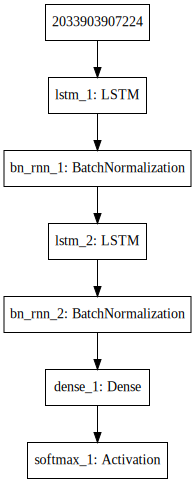

In [19]:
import matplotlib.pyplot as plt
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


plot_model(model, to_file='PoetryModel.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [12]:
# train the model
model.fit(X, y, batch_size=128, epochs=200,verbose = 1)

# save weights
model.save_weights(folder + 'rnn_tang_poetry_weights.hdf5')

Epoch 1/200
18993/18993 [==============================] - 14s 714us/step - loss: 7.4996
Epoch 2/200
18993/18993 [==============================] - 7s 355us/step - loss: 6.7617
Epoch 3/200
18993/18993 [==============================] - 7s 355us/step - loss: 6.4618
Epoch 4/200
18993/18993 [==============================] - 7s 348us/step - loss: 6.0819
Epoch 5/200
18993/18993 [==============================] - 8s 409us/step - loss: 5.7470
Epoch 6/200
18993/18993 [==============================] - 7s 374us/step - loss: 5.5344
Epoch 7/200
18993/18993 [==============================] - 7s 369us/step - loss: 5.3530
Epoch 8/200
18993/18993 [==============================] - 7s 369us/step - loss: 5.1784
Epoch 9/200
18993/18993 [==============================] - 7s 373us/step - loss: 5.0620
Epoch 10/200
18993/18993 [==============================] - 7s 369us/step - loss: 4.9611
Epoch 11/200
18993/18993 [==============================] - 7s 352us/step - loss: 4.8755
Epoch 12/200
18993/18993 [===

In [20]:
# load weights
predict_modell = build_model(hidden_units, window_size, features, output_dim)
predict_modell.load_weights(folder + 'rnn_tang_poetry_weights.hdf5')
input_chars = ['絕']
predict_input = gen.predict_next_chars(model,input_chars,6, window_size, one_hot=one_hot)
print('predict:', predict_input)

predict: 絕據婕窅群血立


In [21]:
def gen_poetry(model, prefix_ary, poetry_type=5):
#     model.load_weights(folder + 'rnn_tang_poetry1_weights.hdf5')
    poetry_sentence_len = poetry_type - 1
    poetry = []
    for char in prefix_ary:
        predict_input = gen.predict_next_chars(model, [char], poetry_sentence_len, window_size, one_hot=one_hot)
        poetry.append(predict_input)
#         poetry.append('\n')
#         print(predict_input)
    return poetry

In [22]:
prefix_ary = ['絕', '妙', '好', '詩']
# prefix_ary = ['一', '二', '三', '四']
# prefix_ary = ['日', '月', '天', '地']
poetry = gen_poetry(predict_modell, prefix_ary, 5)
print('5言')
print(*poetry, sep='\n')
poetry = gen_poetry(predict_modell, prefix_ary, 7)
print('\n7言')
print(*poetry, sep='\n')

5言
絕峨嵋山何
妙獨憐新妝
好以火對月
詩書步詠神

7言
絕頂誰憐女驪歌
妙獨留勝有人未
好以菲薄車走堂
詩書萬壑帶斜照
